# Project Title
### Data Engineering Capstone Project

#### Project Summary

This project is the capstone project of the Data Engineer Nanodegree program offered by Udacity. There are four datasets being considered in this project, which are: the I94 Immigration Data, World Temperature Data, U.S. City Demographic Data, and the Airport Code Table, details of the mentioned datasets are provided in subsequent code windows. 

The purpose of this project is to assess the provided datasets and create a data model for a data warehouse that is capable of hosting the data obtained from the provided datasets.

The project follows the following steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from pyspark.sql import SparkSession
from pathlib import Path

In [2]:
pd.set_option('display.max_columns', None)

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use?


The aim of this project is to create a data model from the provided datasets. The model will be made up of dimension and fact tables, and the implementation of the model will be accomplished using the pandas dataframe and pyspark. Only US data elements are being considered for the present scope of the project.

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

The datasets in the project are:
1) I94 Immigration Data: This data comes from [the US National Tourism and Trade Office](https://travel.trade.gov/research/reports/i94/historical/2016.html).

2) World Temperature Data: This dataset is hosted on [Kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).

3) U.S. City Demographic Data: This data comes from [OpenSoft](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).

4) Airport Code Table: This is a dataset of airport codes and corresponding cities. It can be found [here](https://datahub.io/core/airport-codes#data).

In [3]:
spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

# df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [4]:
def show_col_nan(df: pd.DataFrame):
    """ This function plots a barchart showing the size of nulls in
        DataFrame column.
    Args:
        df (pd.DataFrame): The analysed dataset.
    Returns:
        None
    """
    nan_count_per_col = df.isnull().sum(axis = 0)
    plt.figure(figsize=(15,5))
    plt.title('Count of nulls in columns')
    nan_count_per_col.plot.bar()
    plt.show()
    

In [5]:
# Read in the immigration schema description to
# denormalise dataset 

def read_label(file_name:str, l1:int, l2:int) -> dict:
    """ Read lines of schema description file and return content 
        as a dictionary.
    Args:
        file_name (str): The schema description filename.
        l1 (int): The starting line index of description file.
        l2 (int): The end line index of description file.
    Returns:
        pd.DataFrame: Dictionary of read content.
    """
    dict_label = {}
    with open(file_name) as f:
        for i, line in enumerate(f):
            if not (i >= l1 and i <= l2):
                continue
            list_label = line.strip().split("=")
            dict_label[list_label[0].strip()] = list_label[1].strip().replace("'", "")
    return dict_label

In [6]:
def clean_port(x:str):
    """ Private function for regularising the `ident` column.
    Args:
        x (str): Data item.
    Returns:
        str: Modified data item.
    """
    if ((x is not None) and 
        x.startswith("K") and
       (len(x) > 3)):
        return x[1:]
    return x

In [7]:
AIRPORT_INPUT_FILE = "airport-codes_csv.csv"
AIRPORT_OUTPUT_FILE = "dwh/airport.parquet"

CITY_DEMO_INPUT_FILE = "us-cities-demographics.csv"
CITY_DEMO_OUTPUT_FILE = "dwh/city_demography.parquet"

I94_INPUT_FILE = "sas_data"
I94_OUTPUT_FILE = "dwh/immigration.parquet"

TEMP_INPUT_FILE = "GlobalLandTemperaturesByCity.csv"
TEMP_OUTPUT_FILE = "dwh/temperature.parquet"

In [8]:
# Read in the data here
airport_df = pd.read_csv(AIRPORT_INPUT_FILE)

In [9]:
airport_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [10]:
print(list(airport_df.columns))

['ident', 'type', 'name', 'elevation_ft', 'continent', 'iso_country', 'iso_region', 'municipality', 'gps_code', 'iata_code', 'local_code', 'coordinates']


In [11]:
# Show numerical data
airport_df.describe()

,elevation_ft
count,48069.000000
mean,1240.789677
std,1602.363459
min,-1266.000000
25%,205.000000
50%,718.000000
75%,1497.000000
max,22000.000000


In [12]:
# Get number of rows and columns
airport_df.shape

(55075, 12)

In [13]:
# Check for nulls and duplicates in identity column
len(airport_df['ident'].value_counts())

55075

In [14]:
# Check for duplicate rows
len(airport_df[airport_df.duplicated(keep='first')])

0

In [15]:
# Number of countries with airport entry
airport_df['iso_country'].value_counts()

US    22757
BR     4334
CA     2784
AU     1963
KR     1376
      ...  
NU        1
CC        1
GI        1
VA        1
MQ        1
Name: iso_country, Length: 243, dtype: int64

In [16]:
# Filter for US data
airport_df = airport_df[airport_df['iso_country'] == "US"]

In [17]:
airport_df.shape

(22757, 12)

In [18]:
# Remove closed airports
airport_df = airport_df[airport_df['type'] != "closed"]

In [19]:
airport_df.shape

(21431, 12)

In [20]:
# Add id 
airport_df.insert(0, "id", "")

In [21]:
print(list(airport_df.columns))

['id', 'ident', 'type', 'name', 'elevation_ft', 'continent', 'iso_country', 'iso_region', 'municipality', 'gps_code', 'iata_code', 'local_code', 'coordinates']


In [22]:
# Clean the ident column
airport_df["id"] = airport_df["ident"].apply(lambda x: clean_port(x))

In [23]:
airport_df.head(3)

,id,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"


In [24]:
# Get number of rows and columns
airport_df.shape

(21431, 13)

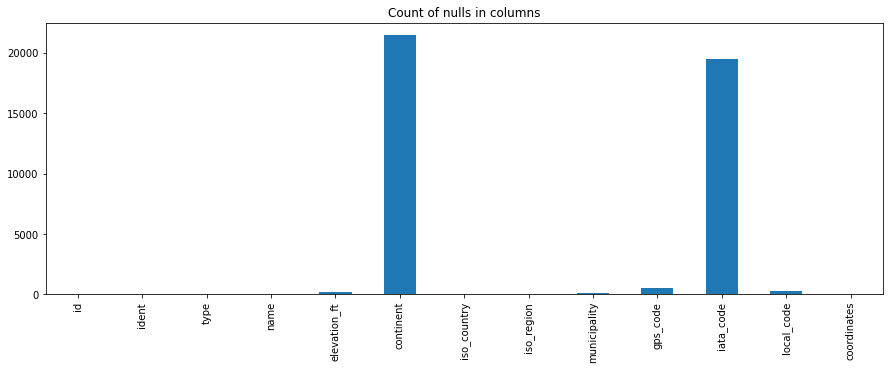

In [25]:
show_col_nan(airport_df)

In [26]:
# Save airport data to filesystem
# airport_df.to_parquet(AIRPORT_OUTPUT_FILE)

In [27]:
# Delete dataframe to free up memory
del airport_df

In [28]:
# fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
# df = pd.read_sas(fname, 'sas7bdat', encoding="ISO-8859-1")

In [29]:
# Read in city demographic data here
city_demo_df = pd.read_csv(CITY_DEMO_INPUT_FILE, delimiter=";")

In [30]:
city_demo_df.sort_values('City')[:7]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
2727,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,Asian,2929
1403,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,Hispanic or Latino,33222
1533,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,White,95487
245,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,American Indian and Alaska Native,1813
2880,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,Black or African-American,14449
2175,Akron,Ohio,38.1,96886.0,100667.0,197553,12878.0,10024.0,2.24,OH,Asian,9033
560,Akron,Ohio,38.1,96886.0,100667.0,197553,12878.0,10024.0,2.24,OH,Black or African-American,66551


In [31]:
city_demo_df.shape

(2891, 12)

In [32]:
print(list(city_demo_df.columns))

['City', 'State', 'Median Age', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born', 'Average Household Size', 'State Code', 'Race', 'Count']


In [33]:
# Check for duplicate rows
len(city_demo_df[city_demo_df.duplicated(keep='first')])

0

In [34]:
# Convert dataset from long to wide form and 
# create identity column for dataset
list_index = list(city_demo_df.columns)[:-2]
city_demo_df = city_demo_df.pivot(index=list_index, columns='Race', values='Count').reset_index().reset_index()
city_demo_df.rename(columns={'index': 'id'}, inplace=True)
city_demo_df.columns.name = None

In [35]:
city_demo_df.sort_values('City')[:7]

,id,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,American Indian and Alaska Native,Asian,Black or African-American,Hispanic or Latino,White
0,0,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,1813.0,2929.0,14449.0,33222.0,95487.0
1,1,Akron,Ohio,38.1,96886.0,100667.0,197553,12878.0,10024.0,2.24,OH,1845.0,9033.0,66551.0,3684.0,129192.0
2,2,Alafaya,Florida,33.5,39504.0,45760.0,85264,4176.0,15842.0,2.94,FL,NaN,10336.0,6577.0,34897.0,63666.0
3,3,Alameda,California,41.4,37747.0,40867.0,78614,4504.0,18841.0,2.52,CA,1329.0,27984.0,7364.0,8265.0,44232.0
4,4,Albany,Georgia,33.3,31695.0,39414.0,71109,5409.0,861.0,2.38,GA,445.0,650.0,53440.0,1783.0,17160.0
5,5,Albany,New York,32.8,47627.0,50825.0,98452,3643.0,11948.0,2.08,NY,1611.0,8090.0,31303.0,9368.0,58368.0
6,6,Albuquerque,New Mexico,36.0,273323.0,285808.0,559131,37443.0,58200.0,2.49,NM,32243.0,25140.0,26774.0,271854.0,411847.0


In [36]:
# Size of dimension dataset
city_demo_df.shape

(596, 16)

In [37]:
city_demo_df.columns

Index(['id', 'City', 'State', 'Median Age', 'Male Population',
       'Female Population', 'Total Population', 'Number of Veterans',
       'Foreign-born', 'Average Household Size', 'State Code',
       'American Indian and Alaska Native', 'Asian',
       'Black or African-American', 'Hispanic or Latino', 'White'],
      dtype='object')

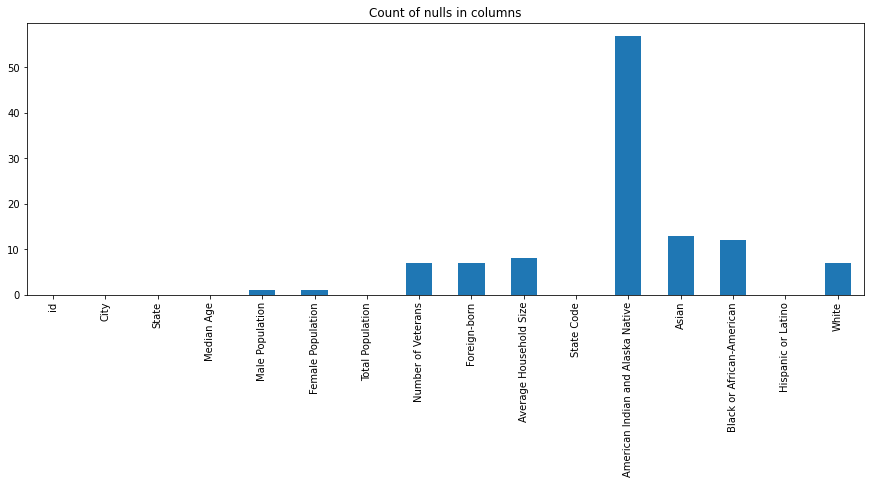

In [38]:
# Show nulls in column
show_col_nan(city_demo_df)

In [39]:
# Save city demography dimension data to filesystem
# city_demo_df.to_parquet(CITY_DEMO_OUTPUT_FILE)

In [40]:
# Delete from memory
del city_demo_df

In [41]:
# Read in immigration data
parquet_df = pd.read_parquet(I94_INPUT_FILE, engine='pyarrow')

In [42]:
parquet_df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,37.0,2.0,1.0,None,None,None,T,None,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,25.0,3.0,1.0,20130811,SEO,None,G,None,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,55.0,2.0,1.0,20160401,None,None,T,O,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,28.0,2.0,1.0,20160401,None,None,O,O,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,4.0,2.0,1.0,20160401,None,None,O,O,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [43]:
parquet_df.shape

(3096313, 28)

In [44]:
# Check for duplicate rows
len(parquet_df[parquet_df.duplicated(keep='first')])

0

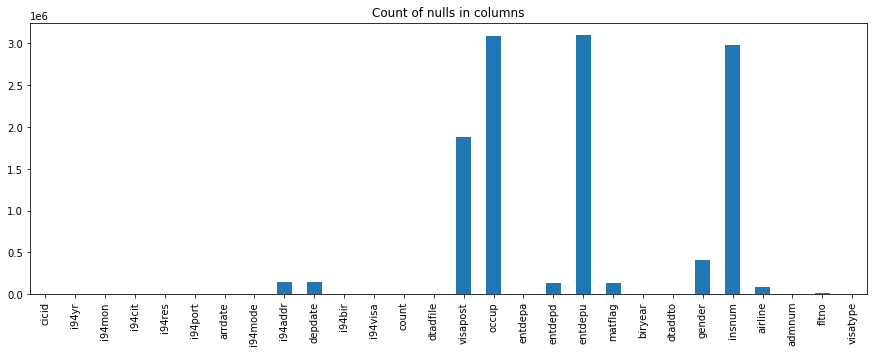

In [45]:
show_col_nan(parquet_df)

In [46]:
print(list(parquet_df.columns))

['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline', 'admnum', 'fltno', 'visatype']


In [47]:
# Create new columns from description file
# i94cit_label
dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=9, l2=297)
parquet_df['i94cit_label'] = parquet_df['i94cit'].apply(
                             lambda x: dict_label.get(str(int(x))) if (x is not None)
                             else None)

# i94res_label
dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=9, l2=297)
parquet_df['i94res_label'] = parquet_df['i94res'].apply(
                             lambda x: dict_label.get(str(int(x))) if x is not None 
                             else None)

# i94port_label
dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=302, l2=961)
parquet_df['i94port_label'] = parquet_df['i94port'].apply(
                              lambda x: dict_label.get(x))

# i94mode_label
dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=972, l2=975)
parquet_df['i94mode_label'] = parquet_df['i94mode'].apply(
                              lambda x: dict_label.get(str(int(x))) if (not np.isnan(x))
                              else None)

# i94addr_label
dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=981, l2=1035)
parquet_df['i94addr_label'] = parquet_df['i94addr'].apply(
                              lambda x: dict_label.get(x))

# i94visa_label
dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=1046, l2=1048)
parquet_df['i94visa_label'] = parquet_df['i94visa'].apply(
                              lambda x: dict_label.get(str(int(x))) if 
                              (not np.isnan(x)) else None)

In [48]:
print(list(parquet_df.columns))

['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline', 'admnum', 'fltno', 'visatype', 'i94cit_label', 'i94res_label', 'i94port_label', 'i94mode_label', 'i94addr_label', 'i94visa_label']


In [49]:
# Save immigration fact data to filesystem
# parquet_df.to_parquet(I94_OUTPUT_FILE)

In [50]:
del parquet_df

In [51]:
# Read in the city temperature data here
temperature_df = pd.read_csv(TEMP_INPUT_FILE)

In [52]:
temperature_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [53]:
temperature_df.shape

(8599212, 7)

In [54]:
print(list(temperature_df.columns))

['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude']


In [55]:
# Filter for US data
temperature_df = temperature_df[temperature_df['Country'] == "United States"]

In [56]:
temperature_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
47555,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W
47556,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W
47557,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W
47558,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W
47559,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W


In [57]:
temperature_df.shape

(687289, 7)

In [58]:
# Check for duplicate rows
len(temperature_df[temperature_df.duplicated(keep='first')])

0

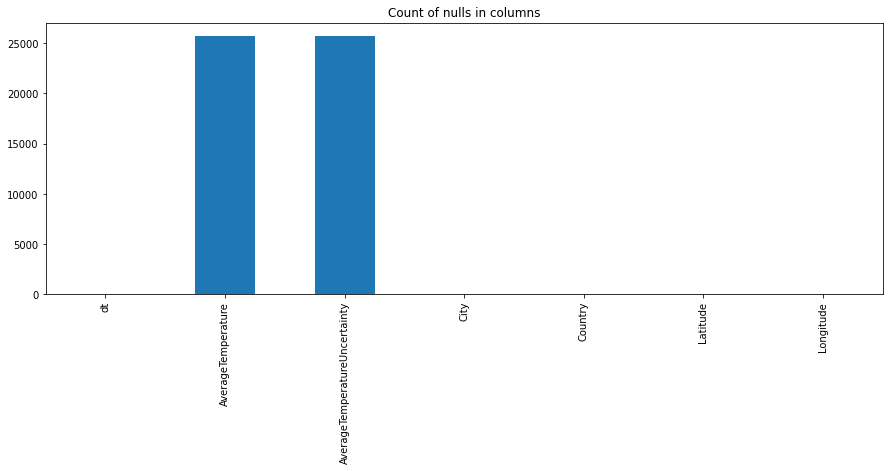

In [59]:
show_col_nan(temperature_df)

In [60]:
# Remove rows with null in either AverageTemperature column
# or AverageTemperatureUncertainty column
temperature_df = temperature_df[
               ~(temperature_df["AverageTemperature"].isnull() |
                 temperature_df["AverageTemperatureUncertainty"].isnull())]

In [61]:
temperature_df.shape

(661524, 7)

In [62]:
# Add id column
temperature_df.insert(0, "id", range(0, len(temperature_df)))

In [63]:
print(list(temperature_df.columns))

['id', 'dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude']


In [64]:
# Save temperature fact data to filesystem
# temperature_df.to_parquet(TEMP_OUTPUT_FILE)

In [65]:
del temperature_df

In [66]:
# Write to parquet
# df_spark.write.parquet("sas_data")
# spark_df=spark.read.parquet("sas_data")

In [67]:
# Drop duplicate rows
# spark_df = spark_df.dropDuplicates()

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

Quality related statistics such as number of nulls in columns and number of duplicate data have been shown in the code windows above.

#### Cleaning Steps
Document steps necessary to clean the data

The cleaning steps will be provided for the different datasets in this project.

1) airport-codes_csv.csv:
- Filter dataset and retain only US datapoints.
- Remove duplicate rows if exists.
- Save airport dimension data to filesystem as the `dwh/airport.parquet` file. 

2) us-cities-demographics.csv: 
- Remove duplicate rows in dataset if exist.
- Convert dataset from the long to wide formatto create the cities dimension table. 
- Add an identity key column to the dataset.
- Save dimension data as the `dwh/city_demography.parquet` file.

3) I94 Immigration Data:
- Remove duplicate rows if exist.
- Create new label columns from description file to denormalise dataset.
- Save fact table to the `dwh/immigration.parquet` file.

4) World Temperature Data
- Filter dataset and retain only US datapoints.
- Remove duplicate rows if exists.
- Remove rows with null in either the AverageTemperature column or the AverageTemperatureUncertainty column.
- Add identity column to dataset.
- Save temperature fact to the `dwh/temperature.parquet` file.

In [68]:
# Performing cleaning tasks here
def process_airport_data(input_file:str, output_file:str):
    """ Extract aiport data, clean, and save dimension data as parquet
        file.
    Args:
        input_file (str): The filename of source data.
        output_file (str): The location to save dimension data.
    Returns:
        None
    """
    
    # Read in the data here
    airport_df = pd.read_csv(input_file)
    
    # Filter for US data
    airport_df = airport_df[airport_df['iso_country'] == "US"]
    
    # Remove closed airports
    airport_df = airport_df[airport_df['type'] != "closed"]
    
    # Add id column
    airport_df.insert(0, "id", "")
    
    # Clean the ident column
    airport_df["id"] = airport_df["ident"].apply(lambda x: clean_port(x))
    
    # Drop duplicates
    airport_df = airport_df[~airport_df.duplicated(keep='first')]
    
    # Save airport dimension data to filesystem
    airport_df.to_parquet(output_file)
    
    # Delete dataframe to free up memory
    del airport_df

In [69]:
def process_demography_data(input_file:str, output_file:str):
    """ Extract city demography data, clean, and save city dimension 
        data in parquet file format.
    Args:
        input_file (str): The filename of source data.
        output_file (str): The location to save dimension data.
    Returns:
        None
    """
    
    # Read in city demographic data here
    city_demo_df = pd.read_csv(input_file, 
                               delimiter=";")
    # Remove duplicate rows
    city_demo_df = city_demo_df[~city_demo_df.duplicated(keep='first')]
    
    # Convert dataset from long to wide form and 
    # create identity column for dataset
    list_index = list(city_demo_df.columns)[:-2]
    city_demo_df = city_demo_df.pivot(index=list_index, columns='Race', values='Count').reset_index().reset_index()
    city_demo_df.rename(columns={'index': 'id'}, inplace=True)
    city_demo_df.columns.name = None
    
    # Save city demography dimension data to filesystem
    city_demo_df.to_parquet(output_file)
    
    # Delete from memory
    del city_demo_df

In [70]:
def process_immigration_data(input_directory:str, output_file:str):
    """ Extract immigration data, clean, and save fact 
        data in parquet file format.
    Args:
        input_directory (str): The directory containing input sas data.
        output_file (str): The location to save fact data.
    Returns:
        None
    """
    # Read in immigration data
    parquet_df = pd.read_parquet(input_directory, engine='pyarrow')
    
    # Remove duplicate rows
    parquet_df = parquet_df[~parquet_df.duplicated(keep='first')]
    
    # Create new columns from description file
    # i94cit_label
    dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=9, l2=297)
    parquet_df['i94cit_label'] = parquet_df['i94cit'].apply(
                                 lambda x: dict_label.get(str(int(x))) if (x is not None)
                                 else None)

    # i94res_label
    dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=9, l2=297)
    parquet_df['i94res_label'] = parquet_df['i94res'].apply(
                                 lambda x: dict_label.get(str(int(x))) if x is not None 
                                 else None)

    # i94port_label
    dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=302, l2=961)
    parquet_df['i94port_label'] = parquet_df['i94port'].apply(
                                  lambda x: dict_label.get(x))

    # i94mode_label
    dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=972, l2=975)
    parquet_df['i94mode_label'] = parquet_df['i94mode'].apply(
                                  lambda x: dict_label.get(str(int(x))) if (not np.isnan(x))
                                  else None)

    # i94addr_label
    dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=981, l2=1035)
    parquet_df['i94addr_label'] = parquet_df['i94addr'].apply(
                                  lambda x: dict_label.get(x))

    # i94visa_label
    dict_label = read_label('I94_SAS_Labels_Descriptions.SAS', l1=1046, l2=1048)
    parquet_df['i94visa_label'] = parquet_df['i94visa'].apply(
                                  lambda x: dict_label.get(str(int(x))) if 
                                  (not np.isnan(x)) else None)
    
    # Save immigration fact data to filesystem
    parquet_df.to_parquet(output_file)
    
    # Delete dataframe
    del parquet_df

In [71]:
def process_temperature_data(input_file:str, output_file:str):
    """ Extract city temperature data, clean, and save fact 
        data in parquet file format.
    Args:
        input_file (str): The source filename.
        output_file (str): The location to save fact data.
    Returns:
        None
    """
    
    # Read in the city temperature data here
    temperature_df = pd.read_csv(input_file)
    
    # Filter for US data
    temperature_df = temperature_df[
                     temperature_df['Country'] == "United States"]
    
    # Remove duplq1`icate rows
    temperature_df = temperature_df[
                    ~temperature_df.duplicated(keep='first')]
    
    # Remove rows with null in either AverageTemperature column
    # or AverageTemperatureUncertainty column
    temperature_df = temperature_df[
                   ~(temperature_df["AverageTemperature"].isnull() |
                     temperature_df["AverageTemperatureUncertainty"].isnull())]
    
    
    # Add id column
    temperature_df.insert(0, "id", range(0, len(temperature_df)))
    
    # Save temperature fact data to filesystem
    temperature_df.to_parquet('dwh/temperature.parquet')
    
    # Delete dataframe
    del temperature_df

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

The data model to be implemented is the star schema. The purpose of this project is to analyse big data and the star schema is best suited for analytical tasks. Given its simplicity, the star schema is efficient in capturing business requirements, minimises the number of joins required in queries, and also allows for partitioning.

The data model will consist of the `airport` and `city_demography` dimension tables as well as the `immigration` and `temperature` fact table.

**Dimension Tables:**
1. airport
    |     | airport | 
    | --- | --------|
    |PK|id|
    ||ident|
    ||type|
    ||name|
    ||elevation_ft|
    ||continent|
    ||iso_country|
    ||iso_region|
    ||municipality|
    ||gps_code|
    ||iata_code|
    ||local_code|
    ||coordinates|

2. city_demography
    |     | city_demography | 
    | --- | --------|
    ||id|
    |PK|City|
    |PK|State|
    ||Median Age|
    ||Male Population|
    ||Female Population|
    ||Total Population|
    ||Number of Veterans|
    ||Foreign-born|
    ||Average Household Size|
    ||State Code|
    ||American Indian and Alaska Native|
    ||Asian|
    ||Black or African-American|
    ||Hispanic or Latino|
    ||White|

**Fact Tables:**
1. immigration
    |     | immigration | 
    | --- | --------|
    ||cicid|
    ||i94yr|
    ||i94mon|
    ||i94cit|
    ||i94res|
    |FK|i94port|
    ||arrdate|
    ||i94mode|
    |FK|i94addr|
    ||depdate|
    ||i94bir|
    ||i94visa|
    ||count|
    ||dtadfile|
    ||visapost|
    ||occup|
    ||entdepa|
    ||entdepd|
    ||entdepu|
    ||matflag|
    ||biryear|
    ||dtaddto|
    ||gender|
    ||insnum|
    ||airline|
    ||admnum|
    ||fltno|
    ||visatype|
    ||i94cit_label|
    ||i94res_label|
    ||i94port_label|
    ||i94mode_label|
    |FK|i94addr_label|
    ||i94visa_label|

2. temperature
    |     | temperature | 
    | --- | ------------|
    ||id|
    ||dt|
    ||AverageTemperature|
    ||AverageTemperatureUncertainty|
    |FK|City|
    ||Country|
    ||Latitude|
    ||Longitude|

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

The steps required to create the data model from the available files include: 
- Extract relevant columns and rows from the airport-codes_csv.csv file to create the airport dimension table. 
- Create city dimension table from the us-cities-demographics.csv file.
- Build the immigration fact table from the parquet files in the sas_data directory.
- Create temperature fact table from the GlobalLandTemperaturesByCity.csv file.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [72]:
def data_pipeline():
    """ The pipeline function for creating data model.
    """
    process_airport_data(AIRPORT_INPUT_FILE, AIRPORT_OUTPUT_FILE)
    
    process_demography_data(CITY_DEMO_INPUT_FILE, CITY_DEMO_OUTPUT_FILE)
    
    process_immigration_data(I94_INPUT_FILE, I94_OUTPUT_FILE)
    
    process_temperature_data(TEMP_INPUT_FILE, TEMP_OUTPUT_FILE)

In [73]:
data_pipeline()

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [74]:
# Perform quality checks here
def get_row_count(input_file:str):
    """ Read in the input dataset in sas format and 
        print the row count.
    Args:
        input_file (str): The sas dataset filename.
    Returns:
        None
    """
    spark_df=spark.read.parquet(input_file)
    row_count = spark_df.count()
    if row_count <= 0:
        raise ValueError(f"Data quality check failed, {input_file} \
                           has no records.")
    print(f"Data quality check for {input_file} passed with"+ \
          f" {row_count} records.")

In [75]:
get_row_count(AIRPORT_OUTPUT_FILE)
get_row_count(CITY_DEMO_OUTPUT_FILE)
get_row_count(I94_OUTPUT_FILE)
get_row_count(TEMP_OUTPUT_FILE)

Data quality check for dwh/airport.parquet passed with 21431 records.
Data quality check for dwh/city_demography.parquet passed with 596 records.
Data quality check for dwh/immigration.parquet passed with 3096313 records.
Data quality check for dwh/temperature.parquet passed with 661524 records.


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

| Table name | Columns | Description | Type |
| ------- | ---------- | ----------- | ---- |
| airport | id, ident, type, name, elevation_ft, continent, iso_country, iso_region, municipality, gps_code, iata_code, local_code, coordinates | The dimension table with attributes of US airports | Dimension table |
| city_demography | id, City, State, Median Age, Male Population, Female Population,Total Population, Number of Veterans, Foreign-born, Average Household Size, State Code, American Indian and Alaska Native, Asian, Black or African-American, Hispanic or Latino, White | A dimension table of US cities' demographic information | Dimension table |
| immigration | cicid, i94yr, i94mon, i94cit, i94res, i94port, arrdate, i94mode, i94addr, depdate, i94bir, i94visa, count, dtadfile, visapost, occup, entdepa, entdepd, entdepu, matflag, biryear, dtaddto, gender, insnum, airline, admnum, fltno, visatype, i94cit_label, i94res_label, i94port_label, i94mode_label, i94addr_label, i94visa_label | A fact table that contains information on i94 immigration | Fact table |
| temperature | id, dt, AverageTemperature, AverageTemperatureUncertainty, City, Country, Latitude, Longitude | Fact table for temperature measurements in US cities | Fact table |

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

#### Rationale for Choice of Tools
The Pandas dataframe has been the preferred choice for the creation of the data model in this project. Although there has been some use of Pyspark, it is done just to have variety. With the ever increasing capacity of computing machines, it now possible to handle millions of records with Pandas. Pandas is a quick solution, and is effective when dealing with less than 10 million records in a standalone computer. 

#### Data Updates
Data should be updated periodically as corresponding changes occur in the real world. For example city codes can be updated, company stock name can change after mergers or acquisition, this changes should be made to the dataset to maintain consistency and high data quality.

#### 100x Increase in Data
For an exponential increase in the raw data, a big data technology such as Pyspark will be more suitable for data processing. A standalone tecnology like Pandas will be too slow to handle such high volumes. Other big data technologies that can be considered include AWS Redshift, and Snowflake.

#### Daily Updates
If periodic updates are required, then the data pipeline needs to be triggered periodically too. A data pipeline management tool like Airflow would be suitable to manage the process of running the data pipeline intermittently.

#### Multiple Accesses
Where the data needs to be accessed by many people in an organisation, then the data should be hosted in online data warehouse in tools such as the AWS S3, or AWS Redshift and users should be granted access based on the least privilege principle.

#### Example Query
What is the municipality of the ports in the top 5 of the highest number of I94 entries in the dataset?

In [76]:
airport_df_spark = spark.read.parquet(AIRPORT_OUTPUT_FILE)
immigration_df_spark = spark.read.parquet(I94_OUTPUT_FILE)

In [77]:
airport_df_spark.createOrReplaceTempView("tbl_airport")
immigration_df_spark.createOrReplaceTempView("tbl_i94")

In [78]:
spark.sql("""
            SELECT i.i94port AS port, 
                    first(a.municipality) AS municipality, 
                    COUNT(i.i94port) AS count
            FROM tbl_i94 AS i
            INNER JOIN tbl_airport AS a
            ON i.i94port = a.id
            GROUP BY i.i94port
            ORDER BY count DESC
            LIMIT 5""").show()

+----+------------+------+
|port|municipality| count|
+----+------------+------+
| MIA|       Miami|343941|
| ORL|     Orlando|149195|
| HHW|        Hugo|142720|
| NEW| New Orleans|136122|
| HOU|     Houston|101481|
+----+------------+------+

